In [1]:
# Copyright 2020 Jaime Tierney

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the license at

# http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and 
# limitations under the License.

# INSTALL NECESSARY PACKAGES PRIOR TO RUNNING THIS NOTEBOOK (SEE README FOR INSTRUCTIONS)
# pytorch
# jupyter 
# numpy
# scipy
# h5py
# matplotlib
# pandas
# livelossplot 

# IMPORT PYTHON PACKAGES
import torch
import os
import numpy as np
import argparse
import json
import sys
from pprint import pprint
import matplotlib.pyplot as plt

# IMPORT FUNCTIONS FROM PROVIDED SOURCE CODE
sys.path.insert(0,'src')
from utils import save_model_params, ensure_dir
from dataloader import ApertureDataset
from model import FullyConnectedNet
from logger import Logger
from trainer_forJupyter import Trainer

In [2]:
# DEFINE MODEL PARAMS
model_params = {}
model_params['save_dir'] = 'models/model_1/k_8/'
# specify whether or not to use GPU (will set to False automatically if no GPU available)
model_params['cuda'] = True
# training data specifications
model_params['k'] = 8 # depth or frequency bin indicator
model_params['training_data_file']='train_data/json/phantom10mm.json'
model_params['batch_size'] = 745
# model architecture parameters
model_params['input_dim'] = 130
model_params['output_dim'] = 130
model_params['layer_width'] = 784
model_params['num_hidden'] = 4
# model regularization parameters
model_params['batch_norm_enable'] = 0
model_params['data_noise_gaussian'] = 1
model_params['dropout_input'] = 0.3
model_params['dropout'] = 0.2
# model weights 
model_params['save_initial'] = 0
model_params['starting_weights'] = None 
# set loss function to 'L1Loss', 'MSELoss', or 'SmoothL1Loss'
model_params['loss_function'] = 'SmoothL1Loss'
# adam optimization parameters
model_params['lr'] = 0.001
model_params['beta1'] = 0.9
model_params['beta2'] = 0.999
model_params['weight_decay'] = 0
# specify stopping criteria
model_params['patience'] = 20

In [3]:
# SPECIFY CUDA AVAILABILITY
print('torch.cuda.is_available(): ' + str(torch.cuda.is_available()))
if model_params['cuda'] and torch.cuda.is_available():
    print('Using ' + str(torch.cuda.get_device_name(0)))
else:
    print('Not using CUDA')
    model_params['cuda']=False
device = torch.device("cuda:0" if model_params['cuda'] else "cpu")

torch.cuda.is_available(): False
Not using CUDA


In [4]:
# LOAD IN THE 10MM DIAMETER PHYSICAL PHANTOM TRAINING DATA 

# load training data specification file
with open(model_params['training_data_file'], 'r') as f:
    data_json = json.load(f)

# load primary training data
dat_list = []
for item in data_json['train']:
    fname = item['file']
    N = int( item['N'])
    dat_list.append(ApertureDataset(fname,N,model_params['k'],0,0))
dat_train = torch.utils.data.ConcatDataset(dat_list)

# load eval training data (subset of primary training data)
dat_list = []
for item in data_json['train_eval']:
    fname = item['file']
    N = int( item['N'])
    dat_list.append( ApertureDataset(fname,N,model_params['k'],0,0))
dat_eval = torch.utils.data.ConcatDataset(dat_list)

# load val data (separate validation set for computing stopping criteria)
dat_list = []
for item in data_json['val']:
    fname = item['file']
    N = int( item['N'])
    dat_list.append( ApertureDataset(fname,N,model_params['k'],0,0))
dat_val = torch.utils.data.ConcatDataset(dat_list)

# setup data loaders
last_batch_size = (len(dat_train) % model_params['batch_size'])
last_batch_size = model_params['batch_size'] if (last_batch_size == 0) else last_batch_size
print(f"\nLast batch size for train data: {last_batch_size}\n")
drop_last = True if ( last_batch_size == 1) else False
print(f"Drop last batch: {drop_last}")
loader_train = torch.utils.data.DataLoader(dat_train, batch_size=model_params['batch_size'],
                                            shuffle=True, num_workers=1, drop_last=drop_last)
drop_last=False
loader_train_eval = torch.utils.data.DataLoader(dat_eval, batch_size=len(dat_eval), 
                                            shuffle=False,num_workers=1,drop_last=drop_last)
drop_last=False
loader_val = torch.utils.data.DataLoader(dat_val, batch_size=len(dat_val), shuffle=False,
                                                num_workers=1, drop_last=drop_last)

# update model params to specify number of training examples
model_params['num_samples_train'] = len(dat_train)
model_params['num_samples_train_eval'] = len(dat_eval)
model_params['num_samples_val'] = len(dat_val)
model_params_path = os.path.join(model_params['save_dir'], 'model_params.txt')
model_params['model_params_path'] = model_params_path
if model_params['save_dir']:
    ensure_dir(model_params['save_dir'])
    save_model_params(model_params_path, model_params)


Last batch size for train data: 78

Drop last batch: False


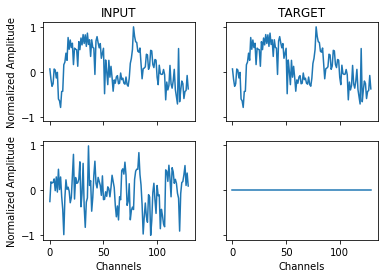

In [5]:
# SHOW TRAINING DATA EXAMPLES

# get example accept region training data
input_example_accept = dat_list[0][0][0]
target_example_accept = dat_list[0][0][1]

# get example reject region training data
input_example_reject = dat_list[0][11][0]
target_example_reject = dat_list[0][11][1]

# set up subplot to show example training signals
fig,axs = plt.subplots(nrows=2,ncols=2,sharey=True,sharex=True)

# plot accept region signals
input_plot_accept=axs[0,0].plot(input_example_accept)
axs[0,0].set_title('INPUT')
axs[0,0].set_ylabel('Normalized Amplitude')
target_plot_accept=axs[0,1].plot(target_example_accept)
axs[0,1].set_title('TARGET')

# plot reject region signals
input_plot_reject=axs[1,0].plot(input_example_reject)
axs[1,0].set_ylabel('Normalized Amplitude')
axs[1,0].set_xlabel('Channels')
target_plot_reject=axs[1,1].plot(target_example_reject)
axs[1,1].set_xlabel('Channels')

# add colorbar and save figure
fig.savefig(os.path.join(model_params['save_dir'],'example_training_data.png'))

In [6]:
# CREATE THE MODEL
model = FullyConnectedNet(input_dim=model_params['input_dim'],
                                output_dim=model_params['output_dim'],
                                layer_width=model_params['layer_width'],
                                dropout=model_params['dropout'],
                                dropout_input=model_params['dropout_input'],
                                num_hidden=model_params['num_hidden'],
                                starting_weights=model_params['starting_weights'],
                                batch_norm_enable=model_params['batch_norm_enable'])
model = model.to(device) # send to GPU if enabled

Initializing network weights randomly.


In [7]:
# SET UP LOSS FUNCTION AND OPTIMIZER

# loss
if model_params['loss_function'] == 'L1Loss':
    loss = torch.nn.L1Loss()
elif model_params['loss_function'] == 'MSELoss':
    loss = torch.nn.MSELoss()
elif model_params['loss_function'] == 'SmoothL1Loss':
    loss = torch.nn.SmoothL1Loss()
loss = loss.to(device) # send to GPU if enabled

# optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=model_params['lr'],
                                betas=(model_params['beta1'], model_params['beta2']),
                                weight_decay=model_params['weight_decay'])

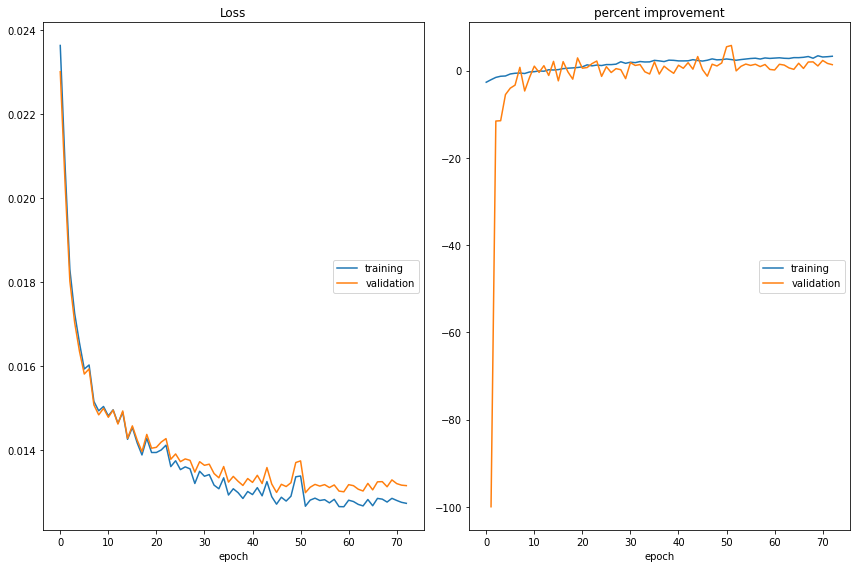

Loss
	training         	 (min:    0.013, max:    0.024, cur:    0.013)
	validation       	 (min:    0.013, max:    0.023, cur:    0.013)
percent improvement
	training         	 (min:   -2.648, max:    3.420, cur:    3.311)
	validation       	 (min:  -99.977, max:    5.785, cur:    1.381)
E: 73 / Train: 1.272e-02 / Valid: 1.315e-02 / Diff Valid: 1.29% / Diff Valid-Train: 3.3% / Time: 26.40


In [8]:
# TRAIN
logger = Logger()
trainer = Trainer(model=model,
                        loss=loss,
                        optimizer=optimizer,
                        scheduler=None,
                        patience=model_params['patience'],
                        loader_train=loader_train,
                        loader_train_eval=loader_train_eval,
                        loader_val=loader_val,
                        cuda=model_params['cuda'],
                        logger=logger,
                        data_noise_gaussian=model_params['data_noise_gaussian'],
                        save_dir=model_params['save_dir'])
trainer.train()